In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from redist import modifier
from redist import plot
from knunu_utils import * 

# Reinterpreting $B \to K \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [2]:
binning = np.linspace(0.0, 22.9, 13) 
bin_cents = (binning[:-1] + binning[1:])/2
q2binning = np.linspace(0.0, 22.9, 24)

## Generate some SM samples

In [3]:
SMsamples = 50000

p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=22.90)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->Knunu::BR', p, k, o)
SMBR = obs.evaluate()

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [4]:
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

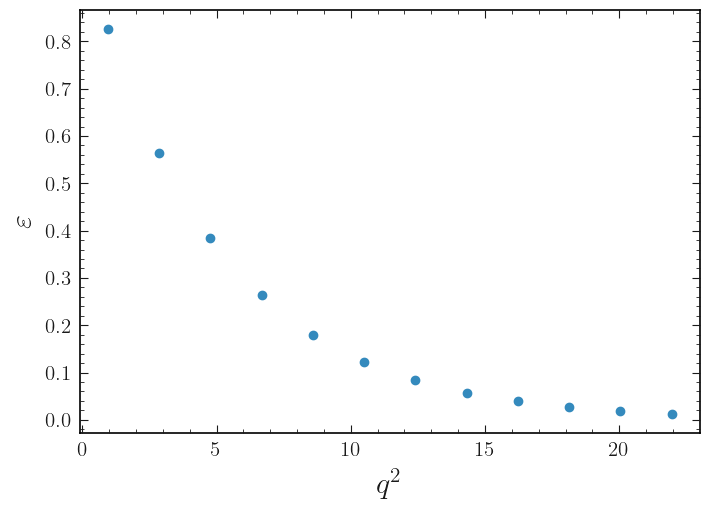

In [5]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

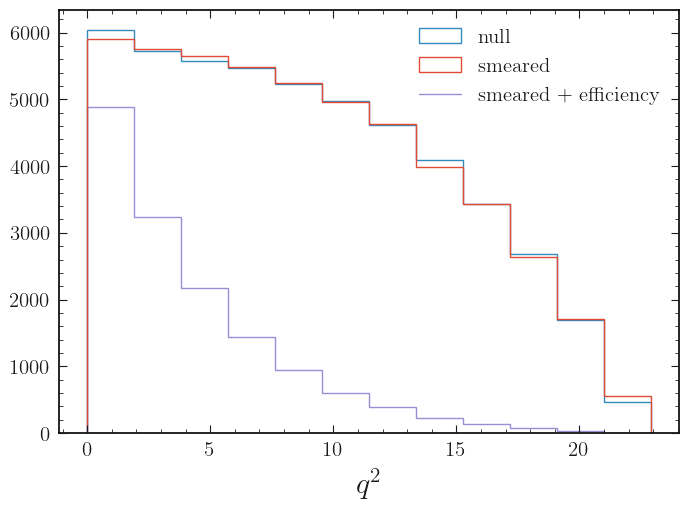

In [6]:
plt.hist(null_samples, binning, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, histtype='step', label='smeared')
null_yields *= efficiency(bin_cents)
plt.stairs(null_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [7]:
p['sbnunu::Re{cVL}'].set(5.0)
p['sbnunu::Re{cVR}'].set(0.5)
p['sbnunu::Re{cSL}'].set(0.5)
p['sbnunu::Re{cSR}'].set(0.5)
p['sbnunu::Re{cTL}'].set(0.5)

BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [8]:
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

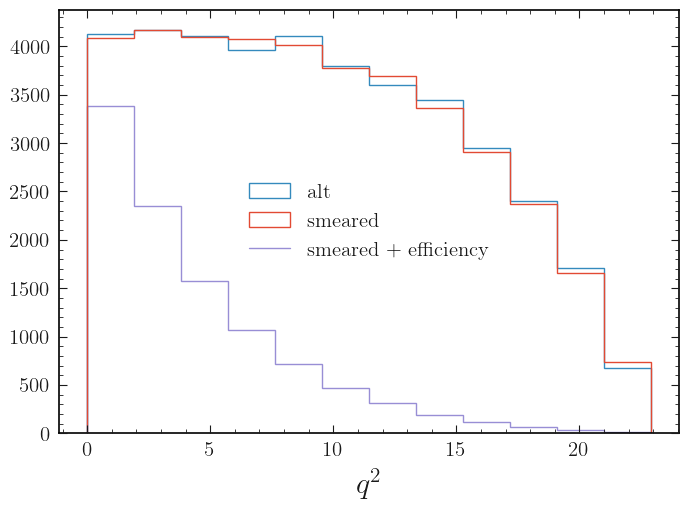

In [9]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
alt_yields, _, _ = plt.hist(alt_samples_smeared, binning, histtype='step', label='smeared')
alt_yields *= efficiency(bin_cents)
plt.stairs(alt_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Set up the mapping distribution

In [10]:
mapping_dist = np.histogramdd([null_samples.flatten(), null_samples_smeared.flatten()], bins=[binning, q2binning])[0]
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [11]:
null = null_pred()
alt = alt_pred()

In [12]:
ana = analysis()
cvl  = ana.parameters['sbnunu::Re{cVL}'        ].evaluate()
cvr  = ana.parameters['sbnunu::Re{cVR}'        ].evaluate()
csl  = ana.parameters['sbnunu::Re{cSL}'        ].evaluate()
csr  = ana.parameters['sbnunu::Re{cSR}'        ].evaluate()
ctl  = ana.parameters['sbnunu::Re{cTL}'        ].evaluate()
fp0 = ana.parameters['B->K::alpha^f+_0@BSZ2015'].evaluate()
fp1 = ana.parameters['B->K::alpha^f+_1@BSZ2015'].evaluate()
fp2 = ana.parameters['B->K::alpha^f+_2@BSZ2015'].evaluate()
f01 = ana.parameters['B->K::alpha^f0_1@BSZ2015'].evaluate()
f02 = ana.parameters['B->K::alpha^f0_2@BSZ2015'].evaluate()
fT0 = ana.parameters['B->K::alpha^fT_0@BSZ2015'].evaluate()
fT1 = ana.parameters['B->K::alpha^fT_1@BSZ2015'].evaluate()
fT2 = ana.parameters['B->K::alpha^fT_2@BSZ2015'].evaluate()

In [13]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7
0,0.000109,0.000696,0.000979,0.000775,0.001303,0.000088,0.000565,0.000760
1,0.000696,0.009307,0.021609,0.005688,0.010247,0.000392,0.006202,0.014710
2,0.000979,0.021609,0.067185,0.008526,0.017058,0.000097,0.011229,0.042544
3,0.000775,0.005688,0.008526,0.006233,0.011288,0.000612,0.004714,0.006588
4,0.001303,0.010247,0.017058,0.011288,0.022037,0.000978,0.008112,0.012782
5,0.000088,0.000392,0.000097,0.000612,0.000978,0.000473,0.003446,0.005830
6,0.000565,0.006202,0.011229,0.004714,0.008112,0.003446,0.031871,0.061918
7,0.000760,0.014710,0.042544,0.006588,0.012782,0.005830,0.061918,0.144128


In [14]:
new_params = {
                'cvl'   :{'inits': (6.0,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'FFK'   :{'inits': (fp0, fp1, fp2, f01, f02, fT0, fT1, fT2), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='knunu')

(<Figure size 700x500 with 1 Axes>,
 <Axes: xlabel='$q^2$ [GeV$^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

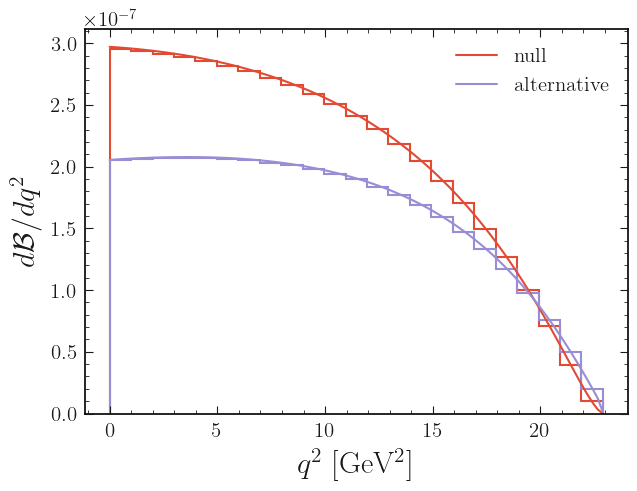

In [15]:
cvl = 5.0
cvr = 0.5
csl = 0.5
csr = 0.5
ctl = 0.5

pars = (cvl, cvr, csl, csr, ctl, fp0, fp1, fp2, f01, f02, fT0, fT1, fT2)
lims = [0.0, 22.9]
labels = [r'$q^2$ [GeV$^2$]', r'$d\mathcal{B}/dq^2$']
plot.dists(cmod, pars, lims, labels)

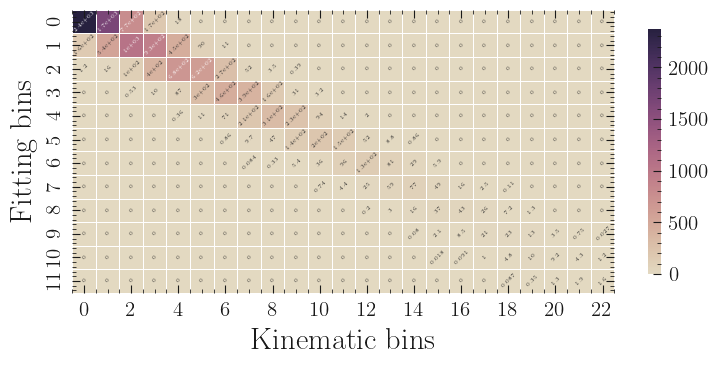

In [16]:
plot.map(cmod)

## Set up the model

In [17]:
spec = {
  "channels": [
    {
      "name": "B->Knunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "knunu_theory",
                "type": "knunu",
                "data":{"expr": "knunu_weight_fn"}
              }

model = modifier.add_to_model(model, ['B->Knunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'B->Knunu',
   'samples': [{'name': 'signal',
     'data': [4883.257404388369,
      3243.087884272497,
      2172.5349991130147,
      1440.642607455261,
      942.6299743536977,
      607.8902483273462,
      386.9061189927594,
      227.87468528355407,
      133.81260836701065,
      70.40152097141687,
      30.99482917350369,
      6.88814244499835],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [69.8803077010138,
        56.94811572187878,
        46.610460189886716,
        37.95579807427662,
        30.70227962796407,
        24.65543040239505,
        19.669929308280683,
        15.095518715286138,
        11.567739985278484,
        8.390561421705753,
        5.5672999895374495,
        2.624527089781767]},
      {'name': 'knunu_theory',
       'type': 'knunu',
       'data': {'expr': 'knunu_weight_fn'}}]}]}]}

## Save and load model

In [18]:
modifier.save('knunu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('knunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [19]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]
# fixed[model.config.par_map['cvr']['slice']] = [True]
# fixed[model.config.par_map['csr']['slice']] = [True]

# pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
# best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 0.419807
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.777697 > 0
W MnPosDef Matrix forced pos-def by adding to diagonal 0.00261799
W VariableMetricBuilder gdel = -18.2878
W MnPosDef Matrix forced pos-def by adding to diagonal 0.393897
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0918902


{'cvl': array([5.50766671, 0.12925133]),
 'cvr': array([2.58440849e-06, 3.59077615e+00]),
 'csl': array([0.34709961, 0.30875002]),
 'csr': array([0.51332838, 0.30968883]),
 'ctl': array([0.6142912 , 0.28548208]),
 'FFK_decorrelated[0]': array([5.22752484e-04, 9.34471632e-01]),
 'FFK_decorrelated[1]': array([0.0078827 , 0.91431227]),
 'FFK_decorrelated[2]': array([0.00364746, 0.82268002]),
 'FFK_decorrelated[3]': array([-1.36908583e-04,  9.48904595e-01]),
 'FFK_decorrelated[4]': array([9.15967165e-05, 9.50121534e-01]),
 'FFK_decorrelated[5]': array([4.59188794e-04, 9.07697754e-01]),
 'FFK_decorrelated[6]': array([-3.67929042e-04,  9.50393282e-01]),
 'FFK_decorrelated[7]': array([0.00236329, 0.94756417]),
 'mu': array([1., 0.]),
 'stat': [[0.9978495468602131, 0.012435354987047342],
  [1.0058181177694459, 0.013969035244684291],
  [0.9967107389897858, 0.016490438966940635],
  [0.999876207351718, 0.020035499046097693],
  [1.00203946841705, 0.024595943984615676],
  [0.9915220349181707, 0.030

In [20]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 5.507666708459216,
 'cvr': 2.584408486038073e-06,
 'csl': 0.3470996133827273,
 'csr': 0.513328375506572,
 'ctl': 0.6142912027552363,
 'FFK[0]': 0.33795779284505945,
 'FFK[1]': -0.8850484611822358,
 'FFK[2]': -0.1127171667936152,
 'FFK[3]': 0.37410561802031567,
 'FFK[4]': 0.07853119272365745,
 'FFK[5]': 0.32697881621681874,
 'FFK[6]': -0.9619475245946969,
 'FFK[7]': -0.27763691647214833,
 'mu': 1.0,
 'stat': [0.9978495468602131,
  1.0058181177694459,
  0.9967107389897858,
  0.999876207351718,
  1.00203946841705,
  0.9915220349181707,
  1.0004784573150367,
  1.0142570283584398,
  0.9963023889712912,
  0.9966087899158045,
  0.9777676578759754,
  1.0525480496116888]}

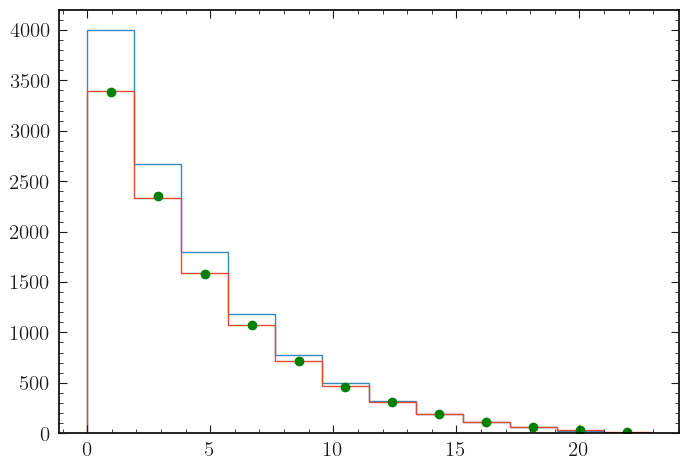

In [21]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')